# Theoretical part:
    
### 1. Hypothesis Testing

##### (a) P(mth experiment gives significant result | m experiments lacking power to reject H0)? <br>

The test's probability of making a type 1 error is $\alpha$ and increases when experiments are repeated.
The first m-1 experiments will have to return an insignificant result, which means they don't have the power to reject the null hypothesis. This would be $(1 - \alpha)$. The probability that the first m-1 experiments gives this result is thus $(1 - \alpha)^{m-1}$. The $m^{th}$ should be a type 1 error. The total probability is therefore $\alpha * (1 - \alpha)^{m-1}$

##### (b) P(at least one significant result | m experiments lacking power to reject H0)? <br>

Instead of looking at the probability of significant results, we can look at the complement of insignificant results, which leads to an easier computation. The probability that all of the experiments are insignificant is $(1 - \alpha)^m$. The probability that at least one is then significant is $1 - (1 - \alpha)^m$ <br>

(The family-wise error rate can then be used for the probability of making one or type 1 errors when performing multiple hypothesis tests. Many procedures to control the familywise error rate exist for this, one we could easily use is the Šidák procedure which tests the hypothesis using the formula $1 - (1 - \alpha)^\frac{1}{m}$. When the $p_i$ is lower or equal to this measure it rejects the null hypothesis.)

### 2. Bias and unfairness in Interleaving experiments

In a situation where we have two lists of documents: $l_1$ with documents $d_1$, $d_2$ and $d_3$ and $l_2$ with documents $d_2$, $d_3$ and $d_4$, both ranked in that order. When only document 3 is relevant, $l_2$ should win every time, since it has a higher ranking. However, with Team Draft interleaving, this does not happen, because the merging to the interleaved happens with coin flips and documents will be skipped when they have already been supplied by another list. When document 3 is the only relevant document, what happens in this situation is that after the skipping, both lists now have document 3 as their next document in the list, which means the coin flip doesn't matter and both lists will have the same relevance, as document 3 is the only relevant document, even though one of the lists is clearly better.

# Experimental Part

## Step 1

In [9]:
%matplotlib inline

import math
import pprint
import itertools
import numpy as np
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=4)

In [10]:
## This block creates all the permutation pairs of P and E

relevance = ['N', 'R', 'HR']

pairs = []

# All permutations of graded relevances of length 5
permutations = list(itertools.product(relevance, repeat=5))

# All possible pairs of P and E assuming they can give the same outcome
for perm in permutations:
    for perm_2 in permutations:
        pairs.append([perm, perm_2])
        
# Show 5000 random pairs uniformly selected
indices = np.random.randint(0, len(pairs), 5000)
sample_pairs = [pairs[i] for i in indices]
pp.pprint(sample_pairs)

[   [('R', 'N', 'R', 'N', 'N'), ('N', 'N', 'R', 'R', 'R')],
    [('N', 'N', 'HR', 'R', 'HR'), ('HR', 'R', 'N', 'R', 'R')],
    [('R', 'N', 'N', 'HR', 'HR'), ('R', 'HR', 'N', 'HR', 'N')],
    [('HR', 'HR', 'N', 'N', 'N'), ('HR', 'HR', 'HR', 'N', 'R')],
    [('HR', 'N', 'R', 'HR', 'HR'), ('N', 'N', 'R', 'R', 'N')],
    [('R', 'R', 'HR', 'R', 'R'), ('R', 'HR', 'R', 'N', 'R')],
    [('R', 'HR', 'R', 'R', 'N'), ('R', 'HR', 'N', 'R', 'HR')],
    [('HR', 'HR', 'R', 'HR', 'HR'), ('R', 'N', 'N', 'HR', 'R')],
    [('R', 'R', 'R', 'R', 'R'), ('R', 'N', 'R', 'N', 'HR')],
    [('HR', 'N', 'N', 'HR', 'HR'), ('HR', 'R', 'R', 'N', 'N')],
    [('HR', 'HR', 'HR', 'N', 'N'), ('HR', 'HR', 'N', 'R', 'N')],
    [('R', 'HR', 'HR', 'HR', 'N'), ('N', 'HR', 'N', 'N', 'N')],
    [('R', 'R', 'R', 'N', 'HR'), ('R', 'N', 'N', 'N', 'R')],
    [('R', 'R', 'R', 'R', 'R'), ('N', 'N', 'N', 'N', 'R')],
    [('HR', 'HR', 'N', 'R', 'HR'), ('HR', 'R', 'N', 'HR', 'N')],
    [('HR', 'R', 'R', 'HR', 'R'), ('R', 'HR', 'R', 'HR'

    [('N', 'N', 'N', 'HR', 'HR'), ('N', 'N', 'N', 'R', 'N')],
    [('HR', 'R', 'HR', 'R', 'R'), ('N', 'HR', 'N', 'R', 'HR')],
    [('R', 'R', 'N', 'R', 'R'), ('HR', 'HR', 'HR', 'R', 'R')],
    [('R', 'N', 'HR', 'R', 'HR'), ('N', 'R', 'HR', 'R', 'N')],
    [('N', 'R', 'HR', 'HR', 'N'), ('R', 'N', 'HR', 'HR', 'HR')],
    [('R', 'HR', 'R', 'HR', 'HR'), ('HR', 'N', 'R', 'N', 'R')],
    [('R', 'N', 'N', 'HR', 'N'), ('HR', 'R', 'N', 'N', 'R')],
    [('N', 'R', 'HR', 'HR', 'R'), ('N', 'N', 'HR', 'N', 'N')],
    [('HR', 'N', 'N', 'N', 'R'), ('R', 'HR', 'N', 'HR', 'R')],
    [('R', 'R', 'HR', 'R', 'HR'), ('R', 'HR', 'R', 'R', 'HR')],
    [('HR', 'N', 'R', 'N', 'R'), ('N', 'HR', 'HR', 'HR', 'HR')],
    [('HR', 'R', 'R', 'R', 'N'), ('R', 'R', 'R', 'HR', 'R')],
    [('R', 'N', 'R', 'HR', 'N'), ('HR', 'HR', 'R', 'N', 'N')],
    [('N', 'R', 'HR', 'R', 'HR'), ('N', 'R', 'R', 'HR', 'N')],
    [('HR', 'R', 'N', 'R', 'R'), ('R', 'HR', 'R', 'HR', 'R')],
    [('HR', 'HR', 'N', 'HR', 'R'), ('N', 'N', 'HR',

    [('HR', 'HR', 'N', 'HR', 'R'), ('R', 'R', 'N', 'N', 'N')],
    [('R', 'N', 'N', 'HR', 'N'), ('HR', 'N', 'R', 'R', 'HR')],
    [('HR', 'N', 'R', 'HR', 'N'), ('R', 'N', 'N', 'R', 'N')],
    [('N', 'R', 'R', 'R', 'N'), ('HR', 'HR', 'HR', 'N', 'HR')],
    [('N', 'N', 'N', 'N', 'R'), ('N', 'N', 'R', 'R', 'R')],
    [('HR', 'R', 'R', 'N', 'N'), ('N', 'N', 'HR', 'R', 'N')],
    [('N', 'HR', 'HR', 'N', 'N'), ('N', 'R', 'N', 'HR', 'N')],
    [('N', 'N', 'HR', 'R', 'N'), ('HR', 'R', 'HR', 'HR', 'R')],
    [('R', 'R', 'R', 'R', 'HR'), ('HR', 'HR', 'R', 'HR', 'N')],
    [('HR', 'N', 'HR', 'R', 'N'), ('R', 'R', 'R', 'N', 'R')],
    [('N', 'HR', 'HR', 'HR', 'N'), ('HR', 'HR', 'N', 'N', 'N')],
    [('HR', 'R', 'N', 'R', 'HR'), ('N', 'R', 'R', 'R', 'N')],
    [('HR', 'N', 'N', 'HR', 'R'), ('R', 'R', 'R', 'HR', 'N')],
    [('N', 'N', 'HR', 'HR', 'R'), ('R', 'N', 'N', 'N', 'HR')],
    [('HR', 'HR', 'HR', 'N', 'R'), ('HR', 'N', 'HR', 'R', 'HR')],
    [('N', 'HR', 'HR', 'R', 'R'), ('R', 'HR', 'HR', 'N

## Step 2 & Step 3

In [11]:
## This block calculates the precision at ranking k of pair P and E and delta measure between the two

# Calculates the precision of a ranking
def precision_at_k(ranking_pair, k):
    precision = 0 
    # Prevent k from being out of total amount of docs in ranking
    if k > len(ranking_pair):
        k = len(ranking_pair)
    for i in range(k):
        if not ranking_pair[i] == 'N':
            precision += 1
            
    return precision / k

k = 10

precision_p = precision_at_k(pairs[1000][0], k) 
precision_e = precision_at_k(pairs[1000][1], k)

print(pairs[1000])

print("Precision of P: {0}".format(precision_p))
print("Precision of E: {0}".format(precision_e))

# Show delta measure of a pair with k = 10
delta_measure_precision = precision_e - precision_p
print("Delta measure of precision: {0}".format(delta_measure_precision))

[('N', 'N', 'N', 'R', 'R'), ('N', 'R', 'N', 'N', 'R')]
Precision of P: 0.4
Precision of E: 0.4
Delta measure of precision: 0.0


In [12]:
## This block calculates the Normalized Discounted Cumulative Gain (nDCG) at rank k of pair P and E
## and the delta measure between the two

# Convert relevance to integers, the higher the more relevant
graded_relevance = {'N': 0, 'R': 1, 'HR': 2}

# Normalized Discounted Cumulative Gain at rank k
def nDCG_at_k(ranking_pair, k, highest_rel):
    nDCG = 0
    best_nDCG = 0
    if k > len(ranking_pair):
        k = len(ranking_pair)
    for i in range(1, k+1):
        # Retrieve relevance
        rel = graded_relevance[ranking_pair[i-1]]
        # Calculate nCDG
        nDCG += (2**rel - 1)/(math.log2(1 + i))
        
        # Assuming ideal is ["HR", "HR", "HR", "HR", "HR"]
        best_nDCG += (2**highest_rel - 1) / (math.log2(1 + i))
        
    # Return normalized nDCG
    return  nDCG / best_nDCG

nDCG_p = nDCG_at_k(pairs[1000][0], k, graded_relevance['HR'])
nDCG_e = nDCG_at_k(pairs[1000][1], k, graded_relevance['HR'])
print("P and E pair:")
print(pairs[1000])
print("")
print("nDCG of P: {0}".format(nDCG_p))
print("nDCG of E: {0}".format(nDCG_e))
delta_measure_nCDG = nDCG_e - nDCG_p
print("Delta measure of nCDG: {0}".format(delta_measure_nCDG))

P and E pair:
[('N', 'N', 'N', 'R', 'R'), ('N', 'R', 'N', 'N', 'R')]

nDCG of P: 0.09242447578501607
nDCG of E: 0.11506378074895644
Delta measure of nCDG: 0.02263930496394037


In [13]:
## This block converts the relevance [N, R, HR] to probabilities [0, 0.25, 0.75]
## It also calculates the Expected Reciprocal Rank of the pair P and E and the delta measure between the two

# Based on ERR paper
def relevance_probabilities(graded_relevance):
    rel_prob = {}
    max_value = max(list(graded_relevance.values()))
    for key, value in graded_relevance.items():
        rel_prob[key] = ((2**value) - 1) / (2**max_value)
    return rel_prob

# Expected Reciprocal Rank
def ERR(ranking_pair, rel_prob):
    sum_r = 0
    for r in range(1, len(ranking_pair) + 1):
        phi_r = rel_prob[ranking_pair[r-1]]
        if r != 1:
            prod_i = 1 
        else:
            prod_i = 0
        for i in range(1, r):
            phi_i = rel_prob[ranking_pair[i-1]]
            prod_i *= (1-phi_i) * phi_r
        sum_r += (1/r) * prod_i
    return sum_r
            

rel_prob = relevance_probabilities(graded_relevance)
print("P and E pair:")
print(pairs[1000])
ERR_p = ERR(pairs[1000][0], rel_prob)
print("ERR of P: {0}".format(ERR_p))
ERR_e = ERR(pairs[1000][1], rel_prob)
print("ERR of E: {0}".format(ERR_e))
delta_measure_ERR = ERR_e - ERR_p
print("Delta measure of ERR: {0}".format(delta_measure_ERR))

P and E pair:
[('N', 'N', 'N', 'R', 'R'), ('N', 'R', 'N', 'N', 'R')]
ERR of P: 0.0044921875
ERR of E: 0.1255859375
Delta measure of ERR: 0.12109375


## Step 4

In [14]:
## This block contains the balanced interleaving algorithm and a random example of applying interleaving. 

# Balanced interleaving algorithm
def balanced_interleaving(ranking1, ranking2):
    I = []
    origin = []
    k_a = 1
    k_b = 1
    # RandBit()
    priority = np.random.randint(0, 2)
    while(k_a <= len(ranking1) or k_b <= len(ranking2)):
        if((k_a < k_b) or ((k_a == k_b) and priority == 1)):
            # Assume ranking1 and ranking2 have different documents
            I.append(ranking1[k_a - 1])
            # Store the origin of the document for credit
            origin.append(0)
            k_a += 1
        else:
            I.append(ranking2[k_b - 1])
            origin.append(1)
            k_b += 1     
    return I, origin

# random doc ids
doc_pairs = [('doc1', 'doc2', 'doc3', 'doc4', 'doc5'), ('doc1', 'doc3', 'doc6', 'doc7', 'doc8')]
I = balanced_interleaving(doc_pairs[0], doc_pairs[1])
print(I)

(['doc1', 'doc1', 'doc2', 'doc3', 'doc3', 'doc6', 'doc4', 'doc7', 'doc5', 'doc8'], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1])


## Step 5

In [15]:
## This block contains the Random Click model algorithm and a random example of its use.

# Random Click Model algorithm
def random_click_model(number_of_clicks, shown_docs):
    # Probability of clicking a document
    p = number_of_clicks / shown_docs
    clicked = []
    for i in range(shown_docs):
        clicked.append(np.random.choice([0, 1], p=[1-p, p]))
    return clicked

# 1 means document at index is clicked
clicked = random_click_model(2, 5)
print("Pair:")
print(pairs[100][0])
print("Clicked indices:")
print(clicked)

Pair:
('N', 'N', 'N', 'N', 'N')
Clicked indices:
[1, 0, 1, 0, 0]


In [16]:
## This block contains the Position-Based model algorithm with the use of EM. The trained gamma values are also shown.

# Position-Based Model training
def train_PBM(sessions, urls_per_query, iterations):
    url_sessions = retrieve_url_sessions(sessions)
    
    old_gamma = init_gamma(urls_per_query)
    old_alpha = init_alpha(url_sessions, len(sessions))
    # Perform EM algorithm every iterations
    for i in range(iterations):
        alpha = E_step(url_sessions, sessions, old_gamma, old_alpha, urls_per_query)
        gamma = M_step(sessions, old_gamma, old_alpha, urls_per_query)
        old_alpha = alpha
        old_gamma = gamma
    return alpha, gamma

# Gamma initialization
def init_gamma(urls_per_query):
    return [0] * urls_per_query

# Alpha initialization for all u (url) and q (sessions)
def init_alpha(url_sessions, dim):
    alpha = {}
    for url in url_sessions:
        alpha[url] = {}
        for session_index in url_sessions[url]:
            alpha[url][session_index] = 0
    return alpha

# E step of the EM algorithm to update alpha
def E_step(url_sessions, sessions, gamma, alpha, urls_per_query):
    # Sum of E-step formula for PBM
    sum_alpha = init_alpha(url_sessions, len(sessions))
    for url in url_sessions:
        for session_index in url_sessions[url]:
            session = sessions[session_index]
            urls = session[0][5:]
            rank = urls.index(url)
            clicked = 0
            if len(session) > 1:
                for click in session[1:]:
                    if click[3] == url:
                        clicked = 1
            # Formula for E-step added to total sum
            sum_alpha[url][session_index] += (1/len(url_sessions[url])) * (clicked + ((1 - clicked) * (((1 - gamma[rank]) * alpha[url][session_index]) / (1 - gamma[rank] * alpha[url][session_index]))))

    return sum_alpha

# M_step of the EM algorthm to update gamma
def M_step(sessions, gamma, alpha, urls_per_query):
    sum_gamma = [0] * urls_per_query
    for i, session in enumerate(sessions):
        session_index = session[0][0]
        query = session[0]
        urls = query[5:]
        clicked_urls = []
        # If clicks in sessions, retrieve the urls
        if len(session) > 1:
            for click in session[1:]:
                clicked_urls.append(click[3])
        for rank, url in enumerate(urls):
            if url in clicked_urls:
                clicked = 1
            else:
                clicked = 0      
            # Formula for M-step PBM
            sum_gamma[rank] += clicked + ((1 - clicked) * ((1 - alpha[url][i]) * gamma[rank]) / (1 - gamma[rank] * alpha[url][i]))
   # Divide by S
    new_gamma = [old_gamma/len(sessions) for old_gamma in sum_gamma]
    return new_gamma

# Store sessions that contain the url in a dictionary {url : [session numbers that contain it]}
def retrieve_url_sessions(sessions):
    url_sessions = {}
    for i, session in enumerate(sessions):
        session_index = int(session[0][0])
        for url in session[0][5:]:
            if url in url_sessions:
                current_sessions = url_sessions[url]
                current_sessions.append(i)
                url_sessions[url] = current_sessions
            else:
                url_sessions[url] = [i]
    return url_sessions

# Store data per session, a query with its clicks [[Session, Clicks]]
def read_click_log():
    with open('YandexRelPredChallenge.txt', 'r') as f:
        data = []
        i = -1
        # Retrieve first 10000 to avoid memory error
        while(i < 10000):
            row = f.readline().split()
            if row[2] == 'Q' or i == -1:
                i += 1
                data.append([])
                data[i].append(row)
            elif row[2] == 'C':
                data[i].append(row)
        return data

data = read_click_log()
_, gamma = train_PBM(data, 10, 12)
print("Gamma values:")
print(gamma)

Gamma values:
[0.998856917406084, 0.9242508986871214, 0.8300189491292622, 0.7441736409407242, 0.634208920239, 0.5564034161893961, 0.5234353387666686, 0.4843255048053378, 0.4429955243336911, 0.45686933066087704]


## Step 6

In [17]:
## This block contains the simulation of an interleaving experiment with both click models. 
## The score of E winning is calculated, with the use of click credit. 
## The click simulation of the PBM model is also present in this block.

# Simulate clicks on the interleaving ranking and 
# check how many times the E ranking won for both the RCM and PBM model
def simulate_interleaving(pair, number_of_clicks, gamma, alpha, N):
    wins_e_random = 0
    wins_e_pbm = 0 
    for _ in range(N):
        p = pair[0]
        e = pair[1]
        interleaved, origin = balanced_interleaving(p, e)
        clicked_random = random_click_model(number_of_clicks, len(interleaved))
        clicked_pbm = click_pbm(interleaved, gamma, alpha)
        score_random = assign_click_credit(origin, clicked_random)
        score_pbm = assign_click_credit(origin, clicked_pbm)
        # Only wins when score is higher, not equal
        if score_random[1] > score_random[0]:
            wins_e_random += 1
        if score_pbm[1] > score_pbm[0]:
            wins_e_pbm += 1     
    return wins_e_random, wins_e_pbm

# Assign the click credit of an interleaved ranking 
def assign_click_credit(origin, clicked):
    score = [0, 0]
    for i, click in enumerate(clicked):
        if click == 1:
            score[origin[i]] += 1
    return score

# Simulate clicks using the PBM model
def click_pbm(interleaved, gamma, alpha):
    clicked = []
    for rank, rel in enumerate(interleaved):
        prob_click = gamma[rank] * alpha[rel]
        clicked.append(np.random.choice([0, 1], p=[1-prob_click, prob_click]))
    return clicked

N = 100
alpha = relevance_probabilities(graded_relevance)
wins_random, wins_pbe = simulate_interleaving(pairs[50000], 2, gamma, alpha, N)
print("E won {0} times out of {1} simulations using random click model".format(wins_random, N))
print("E won {0} times out of {1} simulations using pbm model".format(wins_pbe, N))

E won 28 times out of 100 simulations using random click model
E won 44 times out of 100 simulations using pbm model


## Step 7

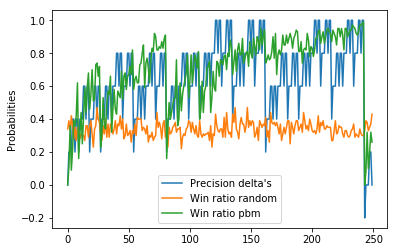

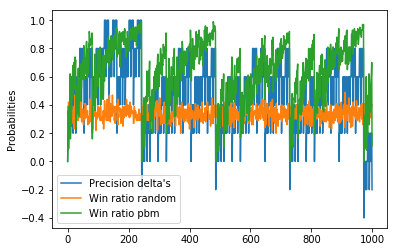

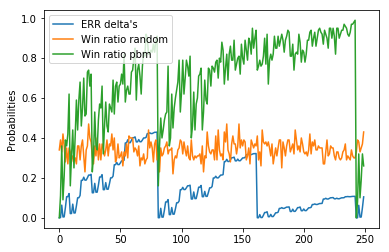

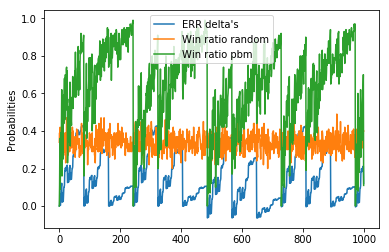

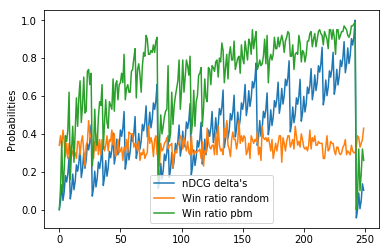

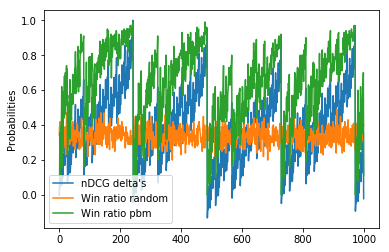

In [18]:
## This block contains the Results of comparison between the offline and online experiments. 
## It plots the results of the different models and visualizes a comparison between the offline and online experiments.


precision_deltas = []
win_ratio_randoms = []
win_ratio_pbms = []
errs = []
ndcgs = []
k = 10

for pair in pairs[:1000]:
    # Interleaving simulation for RCM and PBM
    win_random, win_pbm = simulate_interleaving(pair, 2, gamma, alpha, N)
    P = pair[0]
    E = pair[1]
    
    # Precision P and E
    precision_p = precision_at_k(P, k)
    precision_e = precision_at_k(E, k)
    
    # ERR P and E
    err_p = ERR(P, rel_prob)
    err_e = ERR(E, rel_prob)
    
    # nDCG P and E
    ndcg_p = nDCG_at_k(P, k, graded_relevance['HR'])
    ndcg_e = nDCG_at_k(E, k, graded_relevance['HR'])
    
    # Calculate all delta measures
    precision_delta = precision_e - precision_p
    err_delta = err_e - err_p
    ndcg_delta = ndcg_e - ndcg_p
    win_ratio_random = win_random / N
    win_ratio_pbm = win_pbm / N
    
    # Append all values to list for visualization
    precision_deltas.append(precision_delta)
    errs.append(err_delta)
    ndcgs.append(ndcg_delta)
    win_ratio_randoms.append(win_ratio_random)
    win_ratio_pbms.append(win_ratio_pbm)
    
# Plot first 250 of precision and clickmodels
plt.plot(precision_deltas[:250], label="Precision delta's")
plt.plot(win_ratio_randoms[:250], label='Win ratio random')
plt.plot(win_ratio_pbms[:250], label='Win ratio pbm')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

# Plot first 1000 of precision and click models
plt.plot(precision_deltas, label="Precision delta's")
plt.plot(win_ratio_randoms, label='Win ratio random')
plt.plot(win_ratio_pbms, label='Win ratio pbm')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

# Plot first 250 of ERR and clickmodels
plt.plot(errs[:250], label="ERR delta's")
plt.plot(win_ratio_randoms[:250], label='Win ratio random')
plt.plot(win_ratio_pbms[:250], label='Win ratio pbm')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

# Plot first 1000 of ERR and click models
plt.plot(errs, label="ERR delta's")
plt.plot(win_ratio_randoms, label='Win ratio random')
plt.plot(win_ratio_pbms, label='Win ratio pbm')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

# Plot first 250 of nDCG and click models
plt.plot(ndcgs[:250], label="nDCG delta's")
plt.plot(win_ratio_randoms[:250], label='Win ratio random')
plt.plot(win_ratio_pbms[:250], label='Win ratio pbm')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

# Plot first 1000 of nDCG and click models
plt.plot(ndcgs, label="nDCG delta's")
plt.plot(win_ratio_randoms, label='Win ratio random')
plt.plot(win_ratio_pbms, label='Win ratio pbm')
plt.ylabel('Probabilities')
plt.legend()
plt.show()


In [19]:
def r(x, y):
    return (n * np.sum(x * y) - np.sum(x) * np.sum(y)) \
    / np.sqrt((n * np.sum(x*x) - (np.power(np.sum(x), 2))) \
    * (n * np.sum(y*y) - (np.power(np.sum(y), 2))))

In [21]:
#models = [np.asarray(win_ratio_randoms, dtype=np.float), np.asarray(win_ratio_pbms, dtype=np.float)]
#delta_measures = [np.asarray(precision_deltas, dtype=np.float), np.asarray(errs, dtype=np.float), np.asarray(ndcgs, dtype=np.float)]
n = 1000

r1 = r(np.asarray(win_ratio_randoms[:n]), np.asarray(precision_deltas[:n]))
r2 = r(np.asarray(win_ratio_randoms[:n]), np.asarray(errs[:n]))
r3 = r(np.asarray(win_ratio_randoms[:n]), np.asarray(ndcgs[:n]))
r4 = r(np.asarray(win_ratio_pbms[:n]), np.asarray(precision_deltas[:n]))
r5 = r(np.asarray(win_ratio_pbms[:n]), np.asarray(errs[:n]))
r6 = r(np.asarray(win_ratio_pbms[:n]), np.asarray(ndcgs[:n]))

print("The Pearson correlation coefficient between the random model and precision delta is: ", r1)
print("The Pearson correlation coefficient between the random model and ERR is: ", r2)
print("The Pearson correlation coefficient between the random model and NDCG is: ", r3)
print("The Pearson correlation coefficient between the PBM and precision delta is: ", r4)
print("The Pearson correlation coefficient between the PBM and ERR is: ", r5)
print("The Pearson correlation coefficient between the PBM and NDCG is: ", r6)
        

The Pearson correlation coefficient between the random model and precision delta is:  -0.0504509200949
The Pearson correlation coefficient between the random model and ERR is:  -0.0108633396027
The Pearson correlation coefficient between the random model and NDCG is:  -0.0256599396539
The Pearson correlation coefficient between the PBM and precision delta is:  0.686384407179
The Pearson correlation coefficient between the PBM and ERR is:  0.212749428724
The Pearson correlation coefficient between the PBM and NDCG is:  0.935466534961


A way to look at the correlation between the models and delta measures is using Pearson Correlation Coefficient (PCC). We have shown that in general, these measures highly correlate. The worst correlation was between ERR with the random model. This might be because ERR is an algorithm specifically designed to tackle the downside the assumption made by PCC, which is that is unable to differentiate between dependent and independent variables.

### Conclusion step 7

##### Plot 1 (Precision and Click models)
The results of the precision and the PBM Click model seem to loosely correlate with eachother. An explanation for this behavior could be that precision does not incorperate rank when determining the quality of a ranking, while PBM is heavily based on the rank of a document. 

Another observation seen in the plot is when the precision undergoes a change within ~0.4 the win rate of the PBM model does not change significantly. A possibility for this behavior could be because of the element of randomness that is present in the PBM algorithm. 

For plot 1 the results of the Random Click model are not relevant.

##### Plot 2 (ERR and Click models)
The results of the ERR and the PBM correlate more than shown in plot 1. This could be because the ERR model does take position into account, and also models the examination and attractiveness. And because it also models satisfaction it differs slightly from the PBM model. ERR is more of a cascade model, while the PBM model is position based. This would explain the small differences in behavior.

For plot 2 the resulls of the Random Click model are not relevant.

##### Plot 3 (nDCG and Click models)

The results of the nCDG algorithm have a similar pattern as the results of the PBM algorithm. This could be because the nDCG model measures the ranking quality, which means it models the ranking and relevance of a document. It is heavily based on both position and relevance. This is the same for the PBM model, where gamma models the postion and alpha models the relevance. Which would explain the similarity between the two models. 

##### Interleaving
The win ratio of the PBM model could also become higher when the priority of the balanced interleaving algorithm is given to E. This could be an explanation for the spikiness of the plot. This could also be a reason for the differences with the other models. 
